# Easiest way to download kaggle data in Google Colab

1. Go to your account, Scroll to API section and Click Expire API Token to remove previous tokens

2. Click on Create New API Token - It will download kaggle.json file on your machine.

3. Go to your Google Colab project file and run the following commands:

1. `!pip install -q kaggle`

2. `from google.colab import files`

- `files.upload()`

Choose the kaggle.json file that you downloaded
3. `!mkdir ~/.kaggle`

- `!cp kaggle.json ~/.kaggle/`

Make directory named kaggle and copy kaggle.json file there.
4. `!chmod 600 ~/.kaggle/kaggle.json`

Change the permissions of the file.
5. `!kaggle datasets list`

That's all ! You can check if everything's okay by running this command. Download Data

`!kaggle competitions download -c 'name-of-competition'`

Use unzip command to unzip the data. For example, Create a directory named train, unzip train data there,

`!mkdir train`

`!unzip train.zip -d train`

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile
import random

# data retrieval and categorisation 

In [2]:
# download data
# api = KaggleApi()
# api.authenticate()
# api.competition_download_file('dogs-vs-cats', "train.zip", path="data/dogs-vs-cats")
# api.competition_download_file('dogs-vs-cats', "test1.zip", path="data/dogs-vs-cats")

In [3]:
# unzip downloaded data
# for zipped in os.listdir("data/dogs-vs-cats/"):
#     with zipfile.ZipFile(f"data/dogs-vs-cats/{zipped}") as zipref:
#         zipref.extractall("data/dogs-vs-cats/")
#     os.remove(f"data/dogs-vs-cats/{zipped}")
    
# to save time you can loop through the zip file and extract to directories straight away 
# but I have already done it the hard way so I might as well leave it 

In [4]:
# label images using directories
# path = "data/dogs-vs-cats/train"
# os.mkdir("data/dogs-vs-cats/train/cats")
# os.mkdir("data/dogs-vs-cats/train/dogs")
# for filename in os.listdir(path):
#     if "cat." in filename and os.path.isfile(os.path.join(path, filename)):
#         os.rename(f"{path}/{filename}",f"{path}/cats/{filename}")
#     elif "dog." in filename and os.path.isfile(os.path.join(path, filename)):
#         os.rename(f"{path}/{filename}",f"{path}/dogs/{filename}")


In [5]:
# select some of the labeled data as validation set

# def random_selector(pet_type, k=500):
#     Dir = os.listdir(f"data/dogs-vs-cats/train/{pet_type}")
#     random.shuffle(Dir)
#     return Dir[:k]

# os.mkdir("data/dogs-vs-cats/validation")
# os.mkdir("data/dogs-vs-cats/validation/cats")
# os.mkdir("data/dogs-vs-cats/validation/dogs")

# random_cat_samples = random_selector("cats")
# random_dog_samples = random_selector("dogs")

# for filename in random_cat_samples:
#     os.rename(f"data/dogs-vs-cats/train/cats/{filename}",f"data/dogs-vs-cats/validation/cats/{filename}")
# for filename in random_dog_samples:
#     os.rename(f"data/dogs-vs-cats/train/dogs/{filename}",f"data/dogs-vs-cats/validation/dogs/{filename}")


(-0.5, 498.5, 374.5, -0.5)

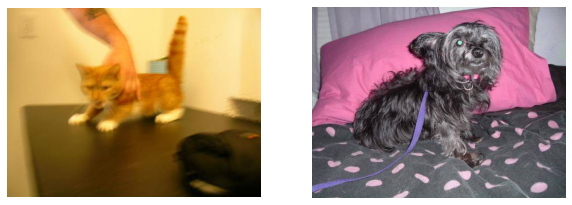

In [2]:
# visualise some of the images

img1 = mpimg.imread(f"data/dogs-vs-cats/train/cats/{os.listdir('data/dogs-vs-cats/train/cats/')[0]}")
img2 = mpimg.imread(f"data/dogs-vs-cats/train/dogs/{os.listdir('data/dogs-vs-cats/train/dogs/')[0]}")
fig, (ax1, ax2) = plt.subplots(1,2, figsize=[10,10])
ax1.imshow(img1)
ax1.axis("off")
ax2.imshow(img2)
ax2.axis("off")

In [3]:
# create test and train generators
train_dir = "data/dogs-vs-cats/train/"
validation_dir = "data/dogs-vs-cats/validation/"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen  = ImageDataGenerator(rescale = 1/255)

train_generator = train_datagen.flow_from_directory(train_dir, batch_size=20, class_mode='binary', target_size=(150, 150))   
validation_generator = test_datagen.flow_from_directory(validation_dir, batch_size=20, class_mode='binary', target_size=(150, 150))                                

Found 24000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# building model

In [3]:
# design model
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [4]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [5]:
# create a callback based on accuracy

class AccuracyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') >= 0.8): 
      print("\nReached 80% accuracy. Cancelling training!")
      self.model.stop_training = True

# create a callback to save model weights
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath="data/modelCheckpoints/cats_dogs_model/", save_weights_only=True, verbose=1)

**If the loss stops going down but the accuracy continues to go up, you are overfitting your data!**

In [12]:
# history = model.fit(train_generator, validation_data=validation_generator, steps_per_epoch=1200, epochs=15, validation_steps=50, verbose=2, callbacks=[AccuracyCallback(), checkpoint_callback])

Epoch 1/15
1200/1200 - 385s - loss: 0.6395 - accuracy: 0.6415 - val_loss: 0.5721 - val_accuracy: 0.7020

Epoch 00001: saving model to data/modelCheckpoints/cats_dogs_model\
Epoch 2/15
1200/1200 - 270s - loss: 0.5789 - accuracy: 0.6990 - val_loss: 0.5241 - val_accuracy: 0.7500

Epoch 00002: saving model to data/modelCheckpoints/cats_dogs_model\
Epoch 3/15
1200/1200 - 269s - loss: 0.5499 - accuracy: 0.7221 - val_loss: 0.5177 - val_accuracy: 0.7550

Epoch 00003: saving model to data/modelCheckpoints/cats_dogs_model\
Epoch 4/15
1200/1200 - 272s - loss: 0.5381 - accuracy: 0.7345 - val_loss: 0.4686 - val_accuracy: 0.7920

Epoch 00004: saving model to data/modelCheckpoints/cats_dogs_model\
Epoch 5/15
1200/1200 - 269s - loss: 0.5190 - accuracy: 0.7516 - val_loss: 0.4436 - val_accuracy: 0.8230

Epoch 00005: saving model to data/modelCheckpoints/cats_dogs_model\
Epoch 6/15
1200/1200 - 270s - loss: 0.5129 - accuracy: 0.7595 - val_loss: 0.5179 - val_accuracy: 0.7810

Epoch 00006: saving model to d

In [8]:
model.load_weights("data/modelCheckpoints/_cats_dogs_model/")

[0.81334466]
6823.jpg is a dog


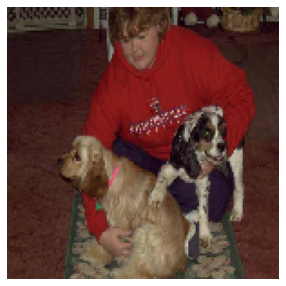

In [44]:
random_choice = random.choice(os.listdir("data/dogs-vs-cats/test1"))
test_img = load_img("data/dogs-vs-cats/test1/"+random_choice, target_size=(150, 150))

fig, ax = plt.subplots(figsize=[5,5])
ax.imshow(test_img)
ax.axis("off")

classes = model.predict(img_to_array(test_img).reshape(1,150,150,3)/255)
print(classes[0])
if classes[0] > 0.5:
    print(random_choice + " is a dog")
else:
    print(random_choice + " is a cat")

# model evaluation

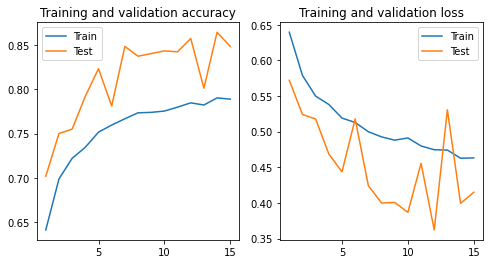

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

fig, axis = plt.subplots(1,2, figsize=[8,4])
axis[0].plot(epochs, acc, label="Train")
axis[0].plot(epochs, val_acc, label="Test")
axis[0].set_title('Training and validation accuracy')
axis[0].legend()

axis[1].plot(epochs, loss, label="Train")
axis[1].plot(epochs, val_loss, label="Test")
axis[1].set_title('Training and validation loss')
axis[1].legend()

The reason why the validation is performing better could be that its a smaller sample. 

If the epochs were to continue, you would see that loss will go down and eventually plateau but the accuracy will initially go up and then reduce in the test set as you are overfitting your training data. 